# Clasificación origen de cepas de _Escherichia coli_ basadas en la presencia / ausencia de genes 

_Juan A. Ugalde_

## Introducción

En este análisis se busca generar un clasificador que nos permita separar cepas de _Escherichia coli_ en base a su origen geógrafico. Para realizar este análisis, contamos con una collección de 464 cepas de _Escherichia coli_, proveniente de 3 lugares diferentes:

- Hospital Padre Hurtado
- Hospital de Curicó
- MAUCO

En el caso de los hospitales, estas correspoden a cepas que fueron obtenidas desde pacientes hospitalizados, y representan una mirada de lo que esta circulando en el ambiente hospitalario. En el caso de MAUCO es un estudio que busca evaluar cual es la portación de cepas de interes, en la comunidad.

En este reporte, vamos a utilizar la información ya procesada de los genomas de estas cepas, las cuales fueron previamente secuenciadas y procesadas a través de un [flujo de trabajo bioinformático](https://github.com/gene2dis/mgap). Estos genomas fueron comparados a través de una estrategia de genomica comparativa, la cual nos permite identificar que genes estan compartidos entre una o mas cepas y cuales genes son únicos (análisis pangenómico). 

El análisis de pangenoma nos permite identificar que genes podrían ser únicos a una cepa (o a un grupo de estas), lo cual refleja las condiciones en las cuales este organismo se encuentra. Por ejemplo, algunas cepas pueden compartir ciertos genes de resistencia a un antibiotico que otras no, y esto refleja su historia evolutiva y su origen. En este análisis queremos ver si a partir de esta información, podemos diferenciar las cepas en base a su lugar de aislamiento e identificar genes y/o grupos.



In [57]:
# Librerias a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import upsetplot
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')


## Preparación de datos y análisis exploratorio

### Preparación de los datos

Primero vamos a cargar la matriz de presencia/ausencia y evaluar algunas características de esta

In [43]:
# Cargar la matriz de presencia/ausencia
ecoli = pd.read_csv("../data/Pangenome_Ecoli_CDC1/gene_presence_absence.csv.gz")

# Los gnombres de los genomas empiezan con SCL. De los datos solo me interesa mantener esas columnas, con la información de los genes
# y el nombre de gen que es un ID unico
scl_columns = [col for col in ecoli.columns if col.startswith('SCL')]
selected_columns = ['Gene'] + scl_columns
filtered_ecoli = ecoli[selected_columns]
filtered_ecoli.head()

,Gene,SCL2541,SCL2543,SCL2550,SCL2551,SCL2554,SCL2558,SCL2559,SCL2570,SCL2571,...,SCL4589,SCL4590,SCL4591,SCL4592,SCL4596,SCL4599,SCL4600,SCL4642,SCL4643,SCL4645
0,kbp,DKODGG_11810,CMKOAP_19455,NJONMK_06915,IKEJAP_21900,CHNPBE_16250,DJFJLG_17335,CIAELK_20170,KFCNIB_13105,ILEFPO_21105,...,MNJJDM_15765,GGBKOJ_12940,MLOCOP_10685,LHFFDG_13305,HANOMK_22590,JLDBEE_14205,HMOFKN_15855,HJBOPB_12380,NPEMDJ_12385,KDOBBD_26205
1,yfeY,DKODGG_11985,CMKOAP_12185,NJONMK_19550,IKEJAP_10815,CHNPBE_13575,DJFJLG_21600,CIAELK_05330,KFCNIB_14650,ILEFPO_19455,...,MNJJDM_14495,GGBKOJ_08560,MLOCOP_17185,LHFFDG_07190,HANOMK_03870,JLDBEE_19265,HMOFKN_03790,HJBOPB_05375,NPEMDJ_05535,KDOBBD_19795
2,moeA,DKODGG_12005,CMKOAP_21370,NJONMK_12580,IKEJAP_12990,CHNPBE_09315,DJFJLG_09845,CIAELK_11530,KFCNIB_19920,ILEFPO_10750,...,MNJJDM_19195,GGBKOJ_01580,MLOCOP_07690,LHFFDG_01550,HANOMK_11165,JLDBEE_03780,HMOFKN_05520,HJBOPB_16520,NPEMDJ_16530,KDOBBD_00675
3,yhdT,DKODGG_12590,CMKOAP_08395,NJONMK_08925,IKEJAP_18610,CHNPBE_04600,DJFJLG_20645,CIAELK_09365,KFCNIB_17160,ILEFPO_13780,...,MNJJDM_02195,GGBKOJ_08110,MLOCOP_05840,LHFFDG_09405,HANOMK_08190,JLDBEE_11830,HMOFKN_14070,HJBOPB_04465,NPEMDJ_02680,KDOBBD_02655
4,yegT,DKODGG_13210,CMKOAP_21660,NJONMK_13330,IKEJAP_10220,CHNPBE_15045,DJFJLG_01955,CIAELK_16420,KFCNIB_20625,ILEFPO_23195,...,MNJJDM_05030,GGBKOJ_06050,MLOCOP_14410,LHFFDG_06150,HANOMK_01960,JLDBEE_07090,HMOFKN_09560,HJBOPB_08605,NPEMDJ_08605,KDOBBD_11880


Para poder utilizar estos datos, tengo que transformarlos en una matriz de 0 y 1

In [44]:
# Transponer la matriz para tener los genomas como filas y los genes como columnas

filtered_ecoli.set_index("Gene", inplace=True)
transposed_ecoli = filtered_ecoli.transpose()

transposed_ecoli = transposed_ecoli.reset_index().rename(columns={'index': 'genome_id'})

transposed_ecoli.iloc[:, 1:] = transposed_ecoli.iloc[:, 1:].notna().astype(int)

gene_columns = transposed_ecoli.columns.drop('genome_id')
transposed_ecoli[gene_columns] = transposed_ecoli[gene_columns].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)

transposed_ecoli.head()



Gene,genome_id,kbp,yfeY,moeA,yhdT,yegT,dhaK,alaA,yfcF,lpxL,...,yubJ,Putative cytoplasmic transmembrane protein,group_9961,group_9971,group_9974,multicopper oxidase domain-containing protein,Sulfurtransferase,group_9988,group_9989,Putative nucleoside transporter
0,SCL2541,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,SCL2543,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,SCL2550,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,0,0,0
3,SCL2551,1,1,1,1,1,1,1,1,1,...,0,1,0,0,0,0,0,0,0,0
4,SCL2554,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


Con la matriz ya lista, voy a agregar las etiquetas que me van a servir mas adelante, a partir de metadata. Estas son:

- ST: Secuencitipo, que es una clasificación de la cepa en base a una combinación de marcadores genéticos.
- Center: El lugar de origen del aislamiento de la cepa

In [45]:
# Agregar metadata
metadata = pd.read_csv("../data/ecoli_cdc_metadata.tsv", sep="\t")

# Limpiar la columna Center
metadata['Center'] = metadata['Center'].str.replace("CHL |", "")

md_ecoli = pd.merge(transposed_ecoli, metadata, on="genome_id")
md_ecoli.head()

,genome_id,kbp,yfeY,moeA,yhdT,yegT,dhaK,alaA,yfcF,lpxL,...,group_9961,group_9971,group_9974,multicopper oxidase domain-containing protein,Sulfurtransferase,group_9988,group_9989,Putative nucleoside transporter,Center,ST
0,SCL2541,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,Hospital Padre Hurtado,-
1,SCL2543,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,Hospital Padre Hurtado,-
2,SCL2550,1,1,1,1,1,1,1,1,1,...,1,0,0,0,0,0,0,0,Hospital Padre Hurtado,1193
3,SCL2551,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,Hospital Padre Hurtado,1193
4,SCL2554,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,Hospital Padre Hurtado,-


### Análisis exploratorio

A partir de los datos, podemos hacer algunos análisis exploratorios para ver la distribución de valores y que esta presente. En primer lugar podemos ver la distribución de cepas por lugar de origen

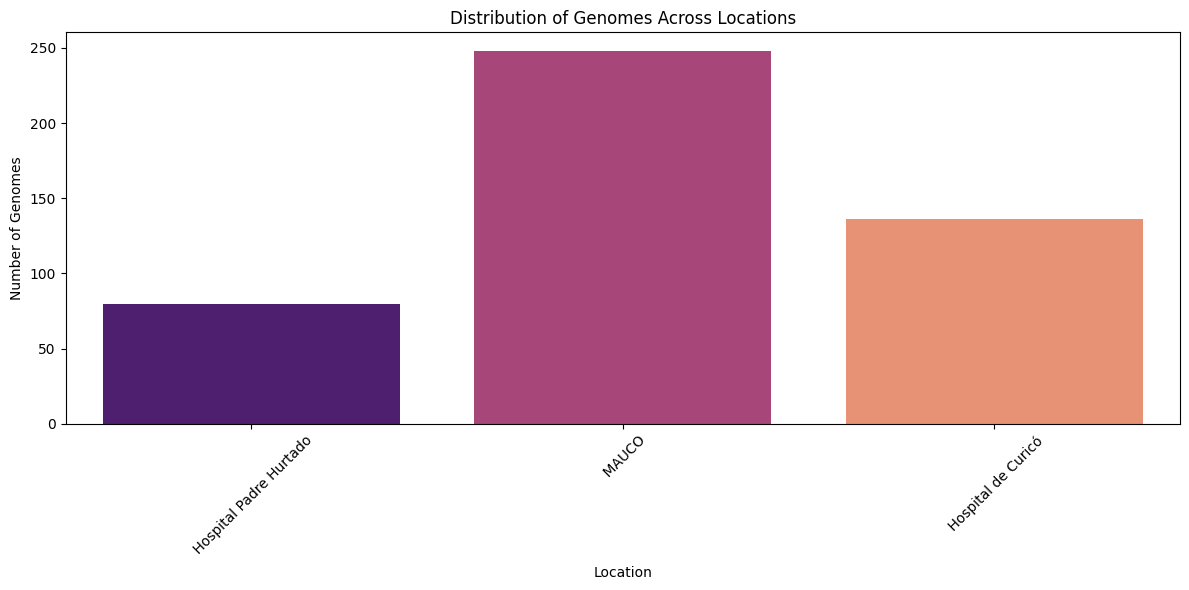

In [48]:
plt.figure(figsize=(12, 6))
sns.countplot(data=md_ecoli, x='Center', palette='magma')
plt.title('Distribution of Genomes Across Locations')
plt.xlabel('Location')
plt.ylabel('Number of Genomes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Vemos que hay un mayor número de cepas comunitarias (MAUCO), comparadas con las cepas que provienen desde hospitales. También podemos evaluar si distribución por STs y por centros, como vemos a continuación

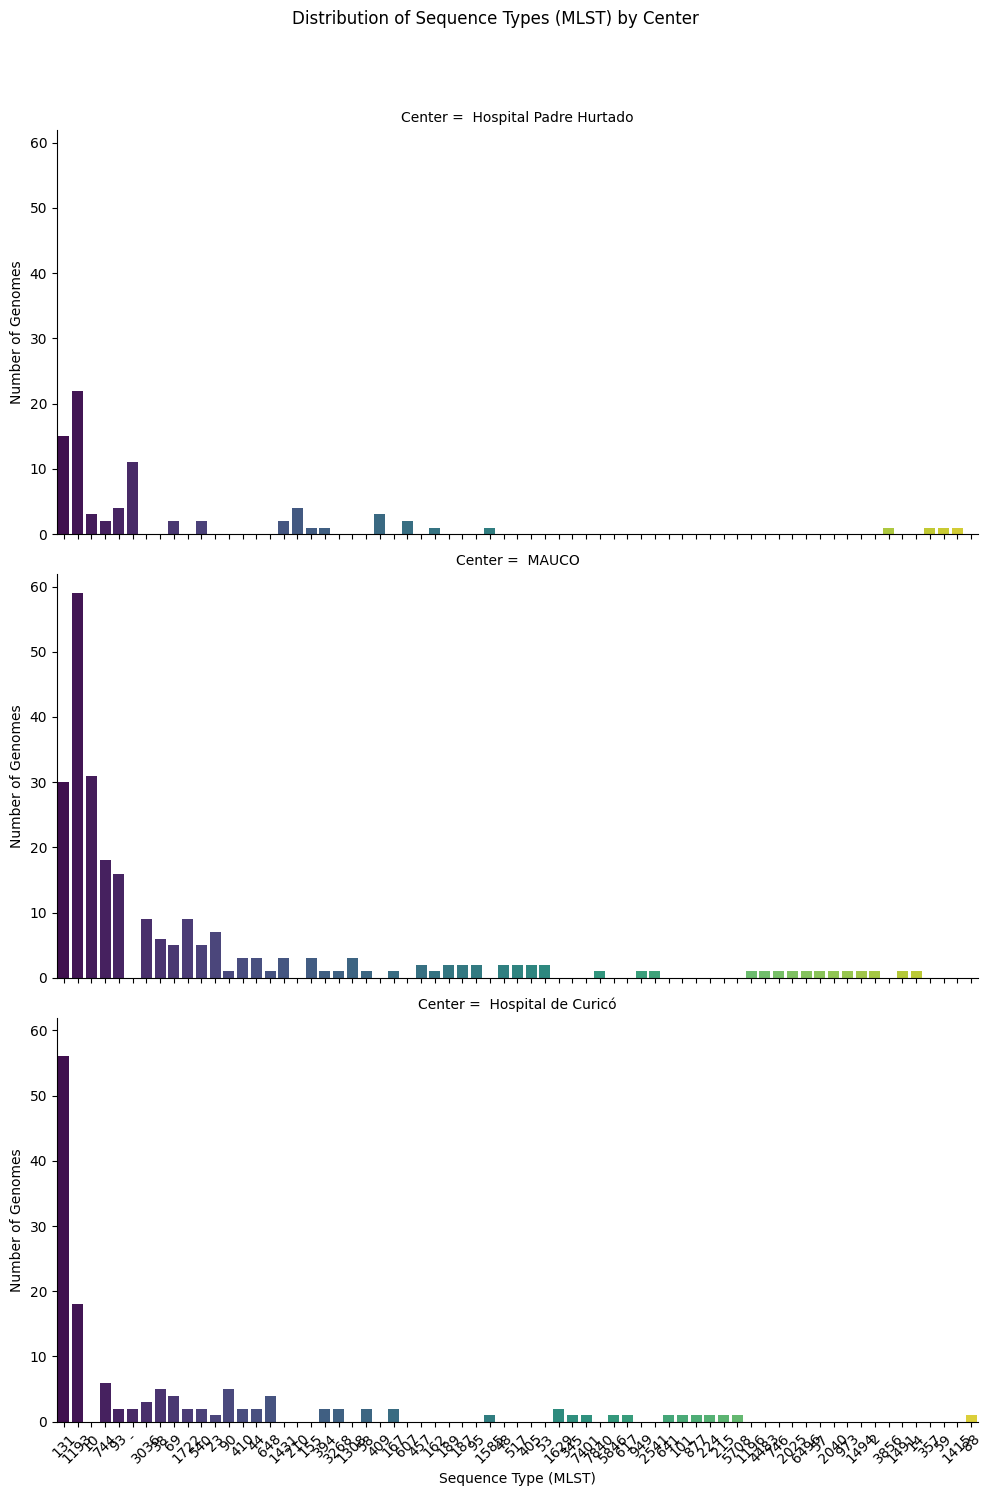

In [49]:
g = sns.FacetGrid(md_ecoli, col="Center", col_wrap=1, height=5, aspect=2, sharex=True)
g.map(sns.countplot, "ST", palette="viridis", order=md_ecoli['ST'].value_counts().index)

for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
    ax.set_xlabel('Sequence Type (MLST)')
    ax.set_ylabel('Number of Genomes')

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Distribution of Sequence Types (MLST) by Center')
plt.show()

A partir del gráfico anterior podemos ver diferencias entre los STs (secuencitipos) y su lugar de origen. También vemos que hay una mayor diversidad de estos en hospitales comparado con lo que vemos en las cepas comunitarias (MAUCO). Esto podría ser indicativo de que hay una mayor variabilidad genética entre estas cepas.

Finalmente, como lo que nos va a interesar es hacer un análisis en base al número de genes compartidos y únicos por cepas y grupos de estas, podemos visualizar esto a través de un gráfico tipo [UpSet](https://pmc.ncbi.nlm.nih.gov/articles/PMC4720993/), el cual permite comparar valores compartidos entre diferentes grupos.

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

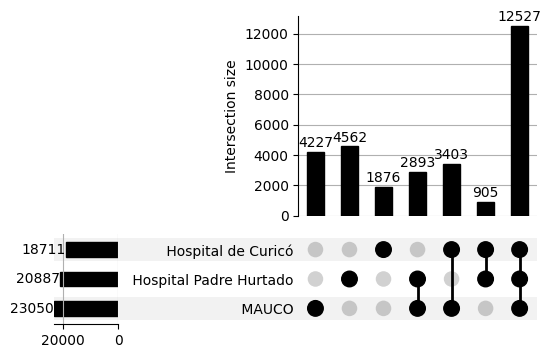

In [53]:
gene_columns = md_ecoli.columns.drop(['genome_id', 'Center', 'ST'])
genes_present_by_location = md_ecoli.groupby('Center')[gene_columns].max()

contents = {}

for location, row in genes_present_by_location.iterrows():
    # Identify genes present in the current location
    present_genes = set(row[row == 1].index)
    contents[location] = present_genes

upset_data = upsetplot.from_contents(contents)

upset = upsetplot.UpSet(upset_data, subset_size='count', show_counts=True, sort_categories_by='cardinality')
upset.plot()


En el gráfico anterior vemos que hay en total 12,527 genes que estan compartidos entre todos los genomas, es decir, estan presentes en todos. Podemos ver ademas de grupos de genes compartidos tanto entre cepas de hospitales y comunitarias, y genes que solo están presentes en las cepas de los hospitales y en las cepas comunitarias.

Este último análisis sugiere que podríamos encontrar genes y/o combinaciones de estos que solo esten presentes en algunas cepas en base a su origen de aislamiento, que nos permitan separar entre estos grupos en base a la matriz de presencia/ausencia.

## Limpieza y preparación de los datos

Esta matriz de datos no requiere mucha limpieza, ya que como es presencia/ausencia de genes, no contiene valores nulos. En esta etapa solamente se aplicaron algunos filtros para limpiar los datos en base a los siguientes criterios:

- Eliminar todos los genes que estan presentes en todos los genomas. Estos no van a ser informativos para el análisis, ya que no permiten discriminar entre grupos
- Eliminar aquellos genes que solo estan presentes en una cepa. La secuenciación de los genomas no es perfecta, y es posible que estemos viendo en algunos casos 1 gen que pueda ser único a una cepa, pero puede ser un artefacto de la secuenación y el anáisis bioinformatico. Idealmente, este tipo de situaciones se deberian corregir previamente, limpiando los datos genómicos, antes de llegar a esta matriz que vamos a utilizar ahora.

In [54]:
# Eliminar genes presentes en todos los genoma

gene_columns = md_ecoli.columns.drop(['genome_id', 'Center', 'ST'])
num_genomes = md_ecoli.shape[0]
gene_sums = md_ecoli[gene_columns].sum()

# Genes present in all genomes
genes_present_in_all = gene_sums[gene_sums == num_genomes].index

# Genes present only once
genes_present_once = gene_sums[gene_sums == 1].index

genes_to_remove = genes_present_in_all.union(genes_present_once)

filtered_gene_columns = gene_columns.difference(genes_to_remove)
filtered_merged_ecoli = md_ecoli[['genome_id', 'Center', 'ST'] + filtered_gene_columns.tolist()]

filtered_merged_ecoli.head()

,genome_id,Center,ST,(2Fe-2S)-binding protein,(D)-galactarate transporter,(Fe-S)-binding protein,(P)ppGpp synthetase,"1,4-beta-xylanase",1-deoxy-D-xylulose-5-phosphate synthase,10 kDa chaperonin,...,zorB,zorE,zorO,zorP,zot,zraP,zraR,zraS,zupT,zwf
0,SCL2541,Hospital Padre Hurtado,-,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,1,0
1,SCL2543,Hospital Padre Hurtado,-,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,1,1
2,SCL2550,Hospital Padre Hurtado,1193,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,1,1
3,SCL2551,Hospital Padre Hurtado,1193,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,1,1,1
4,SCL2554,Hospital Padre Hurtado,-,0,0,0,0,0,0,0,...,1,1,1,0,0,1,1,1,1,1


## Análisis no supervisado

En primera instancia, vamos a realizar un análisis no supervisado, en este caso un PCA, para evaluar si es posible separar los grupos. En primer lugar vamos a estandrizar la data y mirar como los componentes principales explican la varianza de los datos.

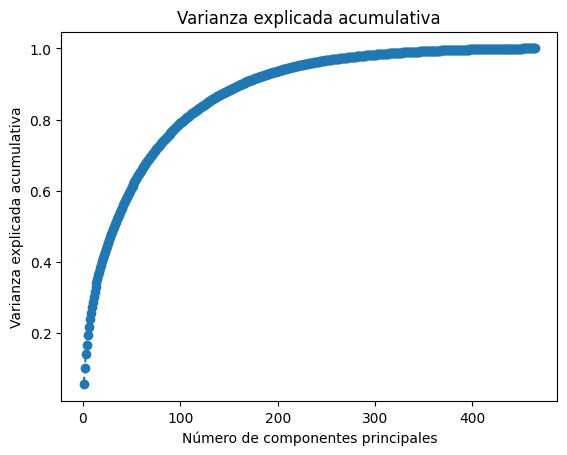

In [60]:
# Estandarización de los datos
data = filtered_merged_ecoli.set_index('genome_id')
gene_data = data.drop(['Center', 'ST'], axis=1)

scaler = StandardScaler()
gene_data_scaled = scaler.fit_transform(gene_data)

pca = PCA()
principal_components = pca.fit_transform(gene_data_scaled)
explained_variance_ratio = pca.explained_variance_ratio_


plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio.cumsum(), marker='o', linestyle='--')
plt.title('Varianza explicada acumulativa')
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza explicada acumulativa')
plt.show()

Se puede apreciar la gran variabilidad que encontramos en los datos, en donde se requiere un gran número de componentes para explicar la varianza de los datos. Uno de los motivos por los cuales esto ocurre es por el tipo de datos con el que estamos trabajando, en donde tenemos un gran número de genes (features) comparado con las observaciones (genomas).

Pese a esto, vamos a evaluar como se veria al realizar un análisis de componentes principales, utilizando los primeros componentes

In [73]:
n_components = 10
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(X)

# Ahora tienes tus datos reducidos a n_components características
pc_df=pd.DataFrame(principal_components, columns=[f'PC{i}' for i in range(1, n_components + 1)], index=gene_data.index)

print(pca.explained_variance_ratio_[0:9].sum())

0.5528672378545846


Vemos que en estos 10 primeros componentes se explica cerca de un 55% de la varianza de los datos

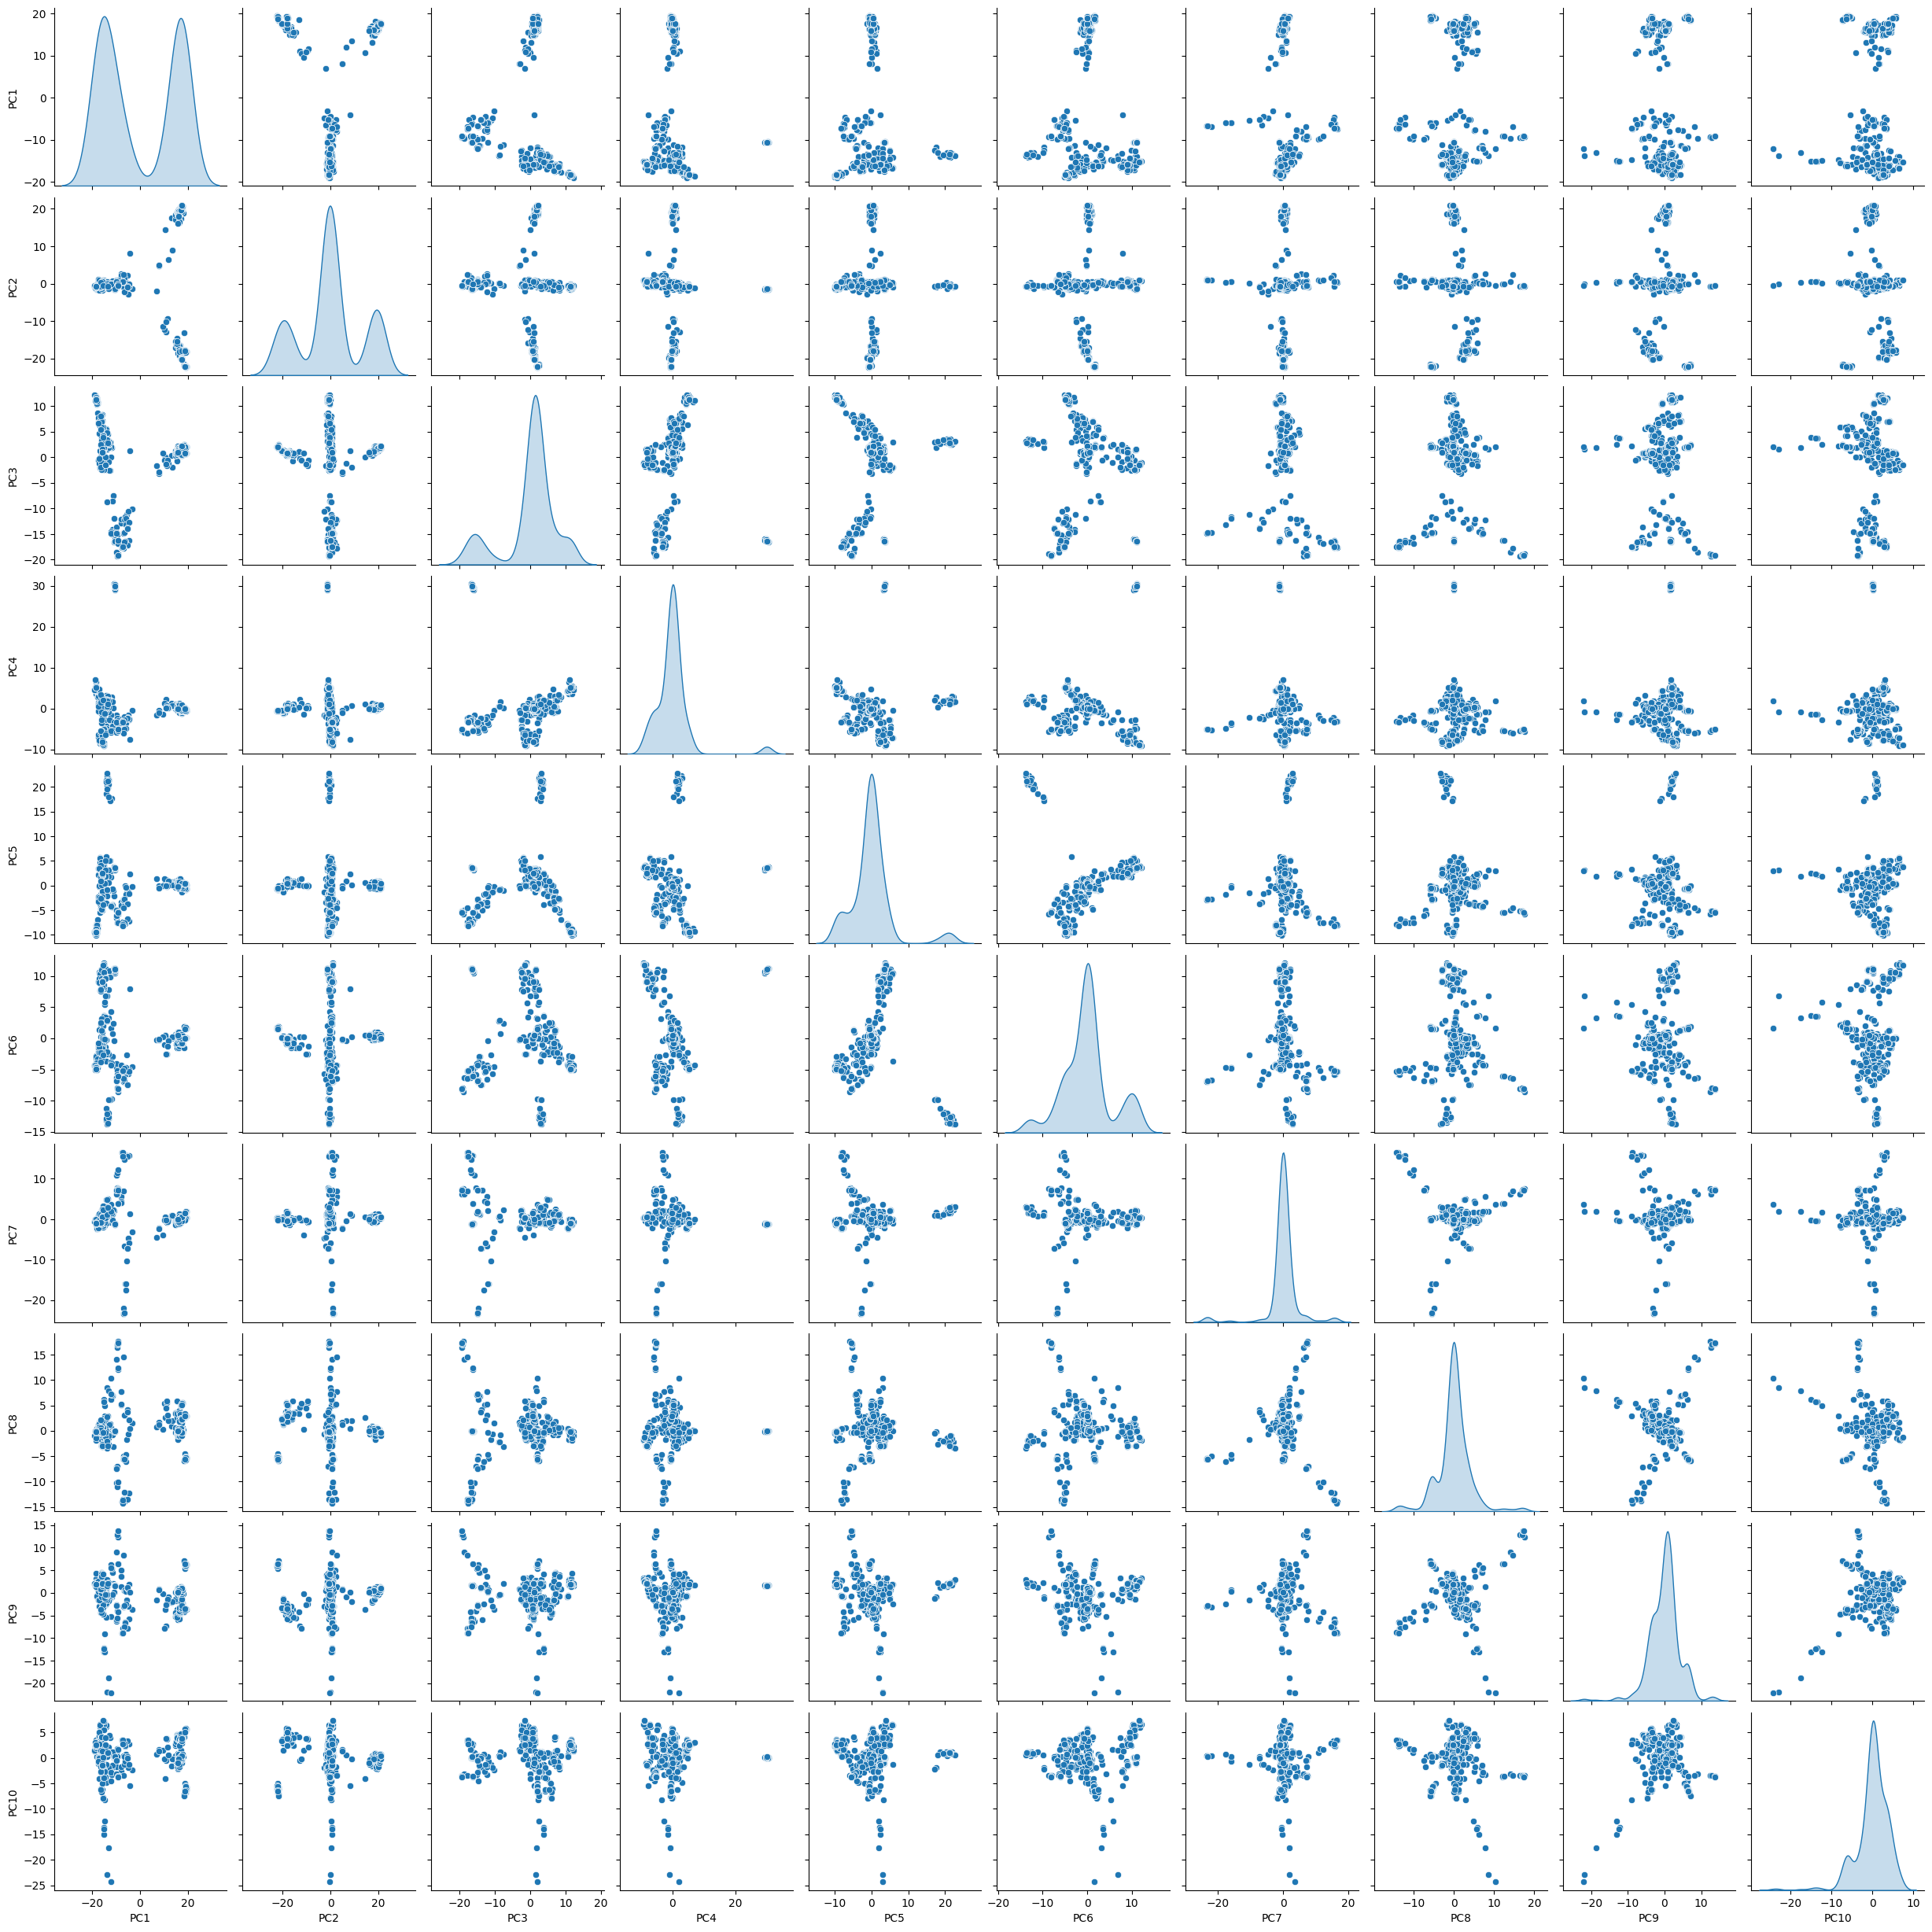

In [69]:
sns.pairplot(pc_df, diag_kind='kde') 
plt.show()

Al graficoar estos componentes, vemos como dependiendo de cuales se visualizan, se forman diferentes grupos. A modo de ejemplo, voy a visualizar los dos primeros componentes, incluyendo su lugar de origen.

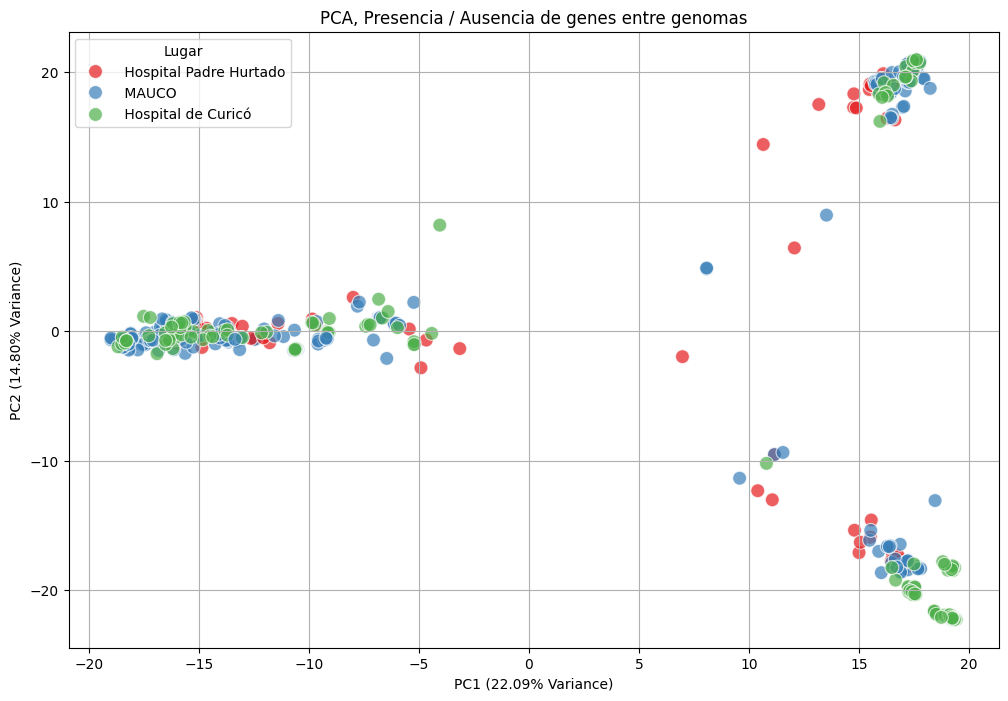

In [74]:
pc_df = pc_df.join(data[['Center','ST']])

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=pc_df,
    x='PC1',
    y='PC2',
    hue='Center',
    palette='Set1',
    s=100,
    alpha=0.7
)

plt.title('PCA, Presencia / Ausencia de genes entre genomas')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)')
plt.legend(title='Lugar')
plt.grid(True)
plt.show()

Entre los 2 primeros componentes se explica cerca de 36% de la varianza de los datos. No vemos una separación por centros, pero si hay una separación que podria estar explicada por otros elementos que no estamos evaluando en este momento, por ejemplo el ST o alguna otra variable que no tenemos en nuestra metadata. Esto podría incluir desde fecha de aislamiento, tipo de infección, por ejemplo.

Podemos evaluar que genes son los que mas contribuyen a cada uno de los componentes principales. Este análisis a futuro nos podría permitir identificar marcadores que permitan predecir lugar de origen para un nuevo aislado.

In [76]:
# Crear un DataFrame con las cargas de cada variable en cada componente principal
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i}' for i in range(1, n_components + 1)], index=gene_data.columns)

#Importancia de las variables
loadings_abs = loadings.abs()

# Mostrar las 5 variables con las cargas más altas para cada componente principal
top_loadings = loadings_abs.apply(lambda x: x.nlargest(5).index)

# Mostrar las cargas
print("Cargas de variables en cada componente principal:")
print(top_loadings)

Cargas de variables en cada componente principal:
                                            PC1  \
0     ABC transporter substrate-binding protein   
1                  Dihydrodipicolinate synthase   
2  Four-carbon acid sugar kinase family protein   
3                    MBL fold metallo-hydrolase   
4                            Response regulator   

                                 PC2          PC3  \
0  DUF3289 domain-containing protein          bfr   
1         6-phospho-beta-glucosidase          bfd   
2                         group_7149         gspJ   
3                               symE  group_12062   
4                        group_14497   group_4770   

                                PC4          PC5          PC6          PC7  \
0                              yhaI   group_5902  group_22946         yfcS   
1  DUF805 domain-containing protein  group_12586   group_2839         cfaC   
2                              ynbC         ldrD   group_8732  group_13321   
3           

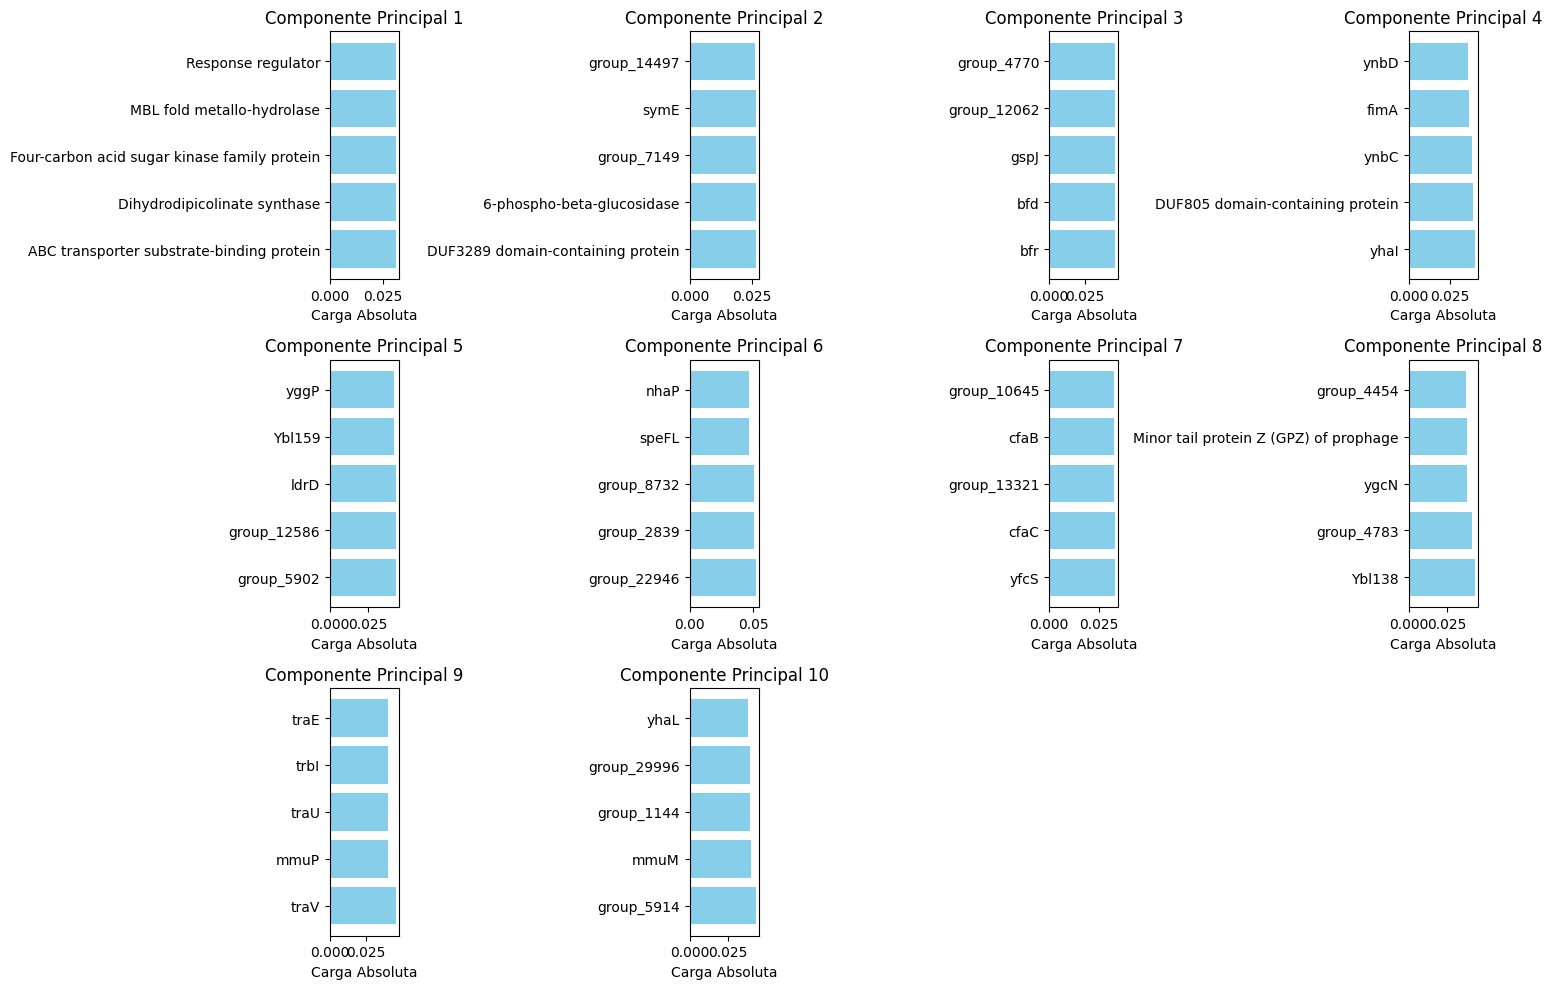

In [77]:
plt.figure(figsize=(15, 10))

for i in range(n_components):
    plt.subplot(3, 4, i + 1) #grafico de 3 filas y 3 columnas para visualizar cada componente
    top_vars = top_loadings[f'PC{i+1}'] #muestra los variables con mayor importancia para cada componente
    loading_values = loadings_abs[f'PC{i+1}'][top_vars]
    plt.barh(top_vars, loading_values, color='skyblue')
    plt.xlabel('Carga Absoluta')
    plt.title(f'Componente Principal {i+1}')

plt.tight_layout()
plt.show()

Es posible identificar algunos genes con funciones conocidas, como reguladores transcripcionales, metabolismo de azucares, entre otros. Pero además se ven genes que no tienen una función facilmente predicha (como group_14497). Estos además de ser candidatos a posibles marcadores, podrían ser buenos targets para futuras exploraciones sobre su rol funcional en estas cepas de _E. coli_.

## Modelos supervisados

En esta segunda parte del análisis, evaluamos para ver si con modelos supervisados nos permite una mejor separación de los grupos e identificar caracteristicas que puedan ser predictoras (y utilizadas posteriormente como marcadores).


### Random Forest

En primer lugar, realizamos un análisis de Random Forest a partir de los datos de la matriz de presencia/ausencia.

Random Forest Accuracy: 0.8071
                         precision    recall  f1-score   support

 Hospital Padre Hurtado       0.94      0.62      0.75        24
     Hospital de Curicó       0.88      0.68      0.77        41
                  MAUCO       0.76      0.93      0.84        75

               accuracy                           0.81       140
              macro avg       0.86      0.75      0.79       140
           weighted avg       0.82      0.81      0.80       140

Random Forest Weighted F1 Score: 0.8023
Random Forest Weighted Precision Score: 0.8246
Random Forest Weighted Recall Score: 0.8071


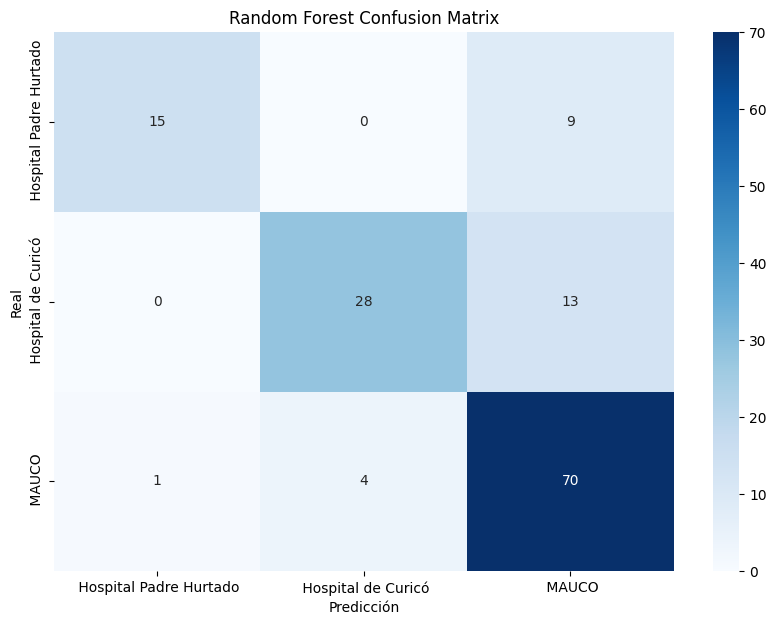

In [85]:
X = filtered_merged_ecoli.drop(['genome_id', 'Center', 'ST'], axis=1)
y = filtered_merged_ecoli['Center']

# Crear set de test y entrenamiento
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Inicializar el clasificador
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'  # Handles class imbalance
)

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_classifier.predict(X_test)

## Evaluar el modelo

# Accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")

# Classification Report

print(classification_report(y_test, y_pred_rf))

# F1 Score (Weighted)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
print(f"Random Forest Weighted F1 Score: {f1_rf:.4f}")

# Precision Score (Weighted)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
print(f"Random Forest Weighted Precision Score: {precision_rf:.4f}")

# Recall Score (Weighted)
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
print(f"Random Forest Weighted Recall Score: {recall_rf:.4f}")

# Matriz de confusión
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=rf_classifier.classes_,
            yticklabels=rf_classifier.classes_)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

El modelo obtuvo una precisión cercana al 80%. A partir de la matrix de confusión, vemos que los principales errores se encuentran en la predicción de cepas comunitarias (MAUCO) con cepas hospitalarias. Esto es interesante, porque surgen algunas posibles explicaciones al respecto.

1. De las limitaciones del modelo, que no permiten realizar la diferenciación solo en base al contenido de los genes, debido a otros elementos que pueden ser relevantes. 
2. Que cepas obtenidas de la comunidad y que estan en la categoria MAUCO, sean realmente cepas hospitalarias, pero estan mal clasificadas desde su origen.

Esto requiere una mirada mas en detalle de la información genomica y la metadata asociada, para limpiar los datos previo al análisis realizado en este proyecto.

También podemos evaluar cuales son los genes (features) mas importantes en el modelo. Estos nos pueden servir a futuro como marcadores para identificar el origen de las cepas, pero además pueden ser candidatos a una exploración experimental, de manera de evaluar que los hace ser genes que estan mas presentes en un grupo de cepas que en en otro

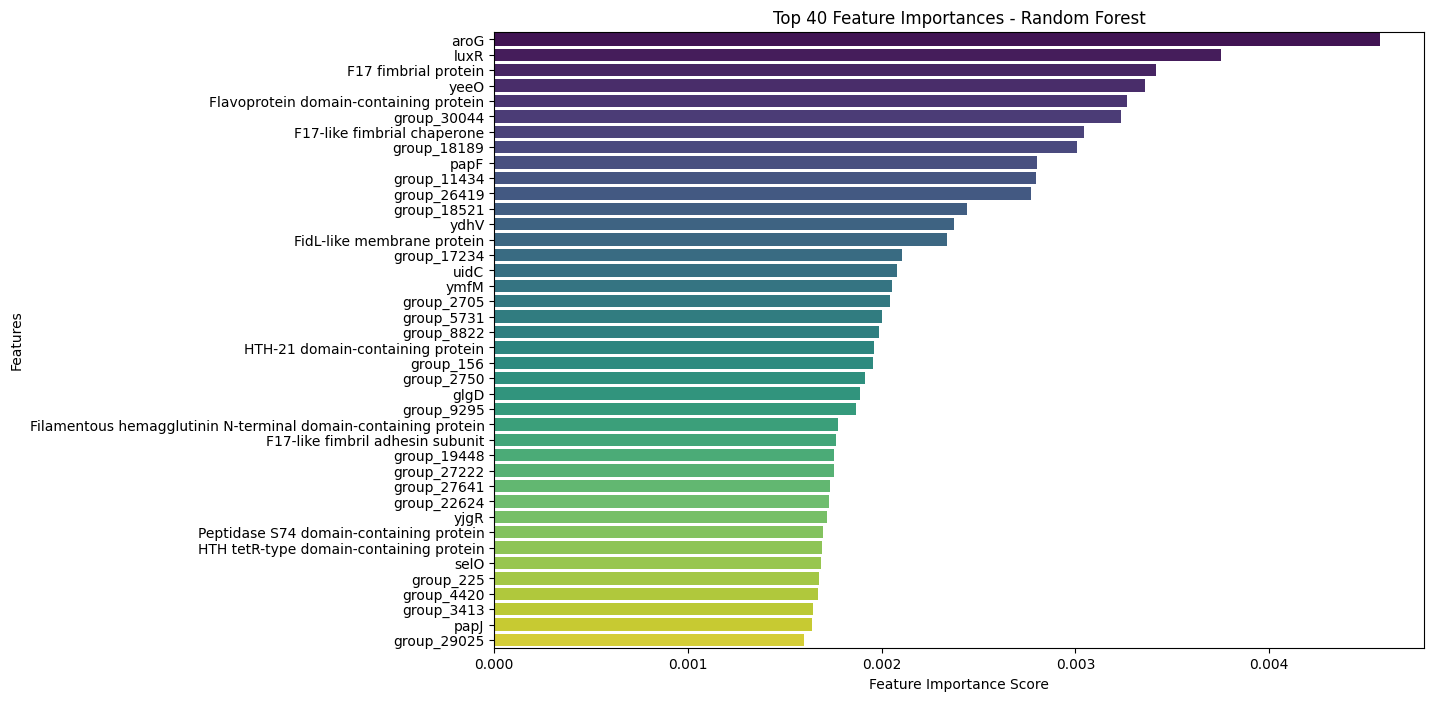

In [86]:
# PLot the feature importance
top_n = 40

plt.figure(figsize=(12, 8))
sns.barplot(x=feature_scores[:top_n], y=feature_scores.index[:top_n], palette='viridis')
plt.title('Top 40 Feature Importances - Random Forest')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.show()

Se observan varios genes que son importantes en el clasificador. Dentro de estos vemos a _aroG_, el cual codifica para un proteina involucrada en la [biosintesis de aminoacidos](https://www.uniprot.org/uniprotkb/P0AB91/entry) y _luxR_, el cual es una [regulador transcripcional](https://www.uniprot.org/uniprotkb/P12746/entry). Este ultimo es un candidato interesante de mirar en detalle, de manera de ver que genes esta encargado de regular y si estos genes estan asociados a temas de virulencia y/o resistencia a antibioticos.

### XGBoost

Como segundo modelo no supervisado, se evaluo XGBoost.

XGBoost Classifier Accuracy: 0.7714
                         precision    recall  f1-score   support

 Hospital Padre Hurtado       0.88      0.58      0.70        24
     Hospital de Curicó       0.79      0.63      0.70        41
                  MAUCO       0.75      0.91      0.82        75

               accuracy                           0.77       140
              macro avg       0.80      0.71      0.74       140
           weighted avg       0.78      0.77      0.76       140

XGBoost Weighted F1 Score: 0.7647
XGBoost Weighted Precision Score: 0.7810
XGBoost Weighted Recall Score: 0.7714


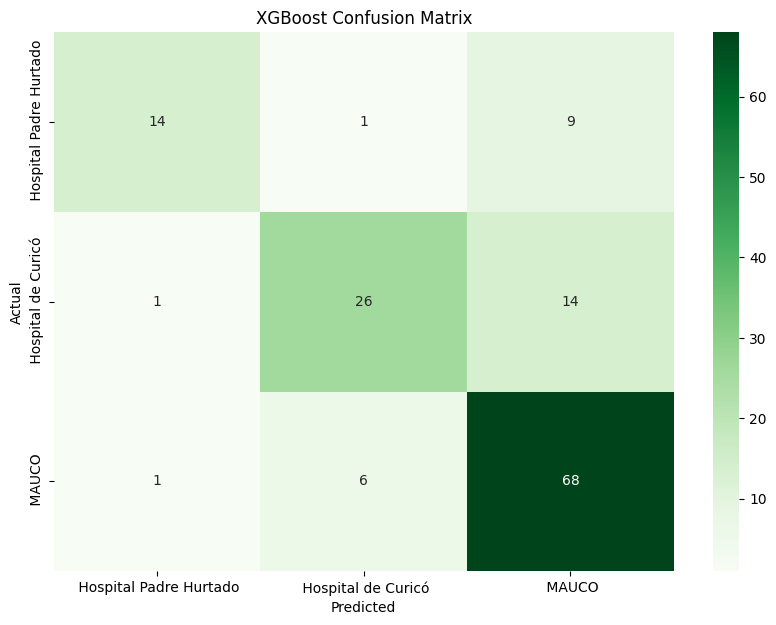

In [87]:

# Crear una copia de los datos
data = filtered_merged_ecoli.copy()

# Features and Target
X = data.drop(['genome_id', 'Center', 'ST'], axis=1)
y = data['Center']

# XGboost no le gustan los caracteres extraños en las columnas
X.columns = X.columns.str.replace(r'[\[\]<>\{\}\(\)]', '_', regex=True)

le = LabelEncoder()
y_encoded = le.fit_transform(y)


# Crear sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# inicializar el clasificador
xgb_classifier = XGBClassifier(
    n_estimators=100,
    learning_rate=0.3,
    max_depth=6,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss',
    scale_pos_weight=1  # Adjust based on class imbalance if necessary
)

# Train 
xgb_classifier.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_classifier.predict(X_test)

# Evaluate
y_pred_xgb_labels = le.inverse_transform(y_pred_xgb)
y_test_labels = le.inverse_transform(y_test)

# Accuracy
accuracy_xgb = accuracy_score(y_test_labels, y_pred_xgb_labels)
print(f"XGBoost Classifier Accuracy: {accuracy_xgb:.4f}")

# Reporte
print(classification_report(y_test_labels, y_pred_xgb_labels))

# F1 Score (Weighted)
f1_xgb = f1_score(y_test_labels, y_pred_xgb_labels, average='weighted')
print(f"XGBoost Weighted F1 Score: {f1_xgb:.4f}")

# Precision Score (Weighted)
precision_xgb = precision_score(y_test_labels, y_pred_xgb_labels, average='weighted')
print(f"XGBoost Weighted Precision Score: {precision_xgb:.4f}")

# Recall Score (Weighted)
recall_xgb = recall_score(y_test_labels, y_pred_xgb_labels, average='weighted')
print(f"XGBoost Weighted Recall Score: {recall_xgb:.4f}")

# Confusion Matrix
conf_matrix_xgb = confusion_matrix(y_test_labels, y_pred_xgb_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


El modelo obtuvo una precisión cercana al 77%%, en donde los errores son similares a lo que observamos con el Random Forest.

Podemos evaluar cuales son los genes mas importantes para este modelo

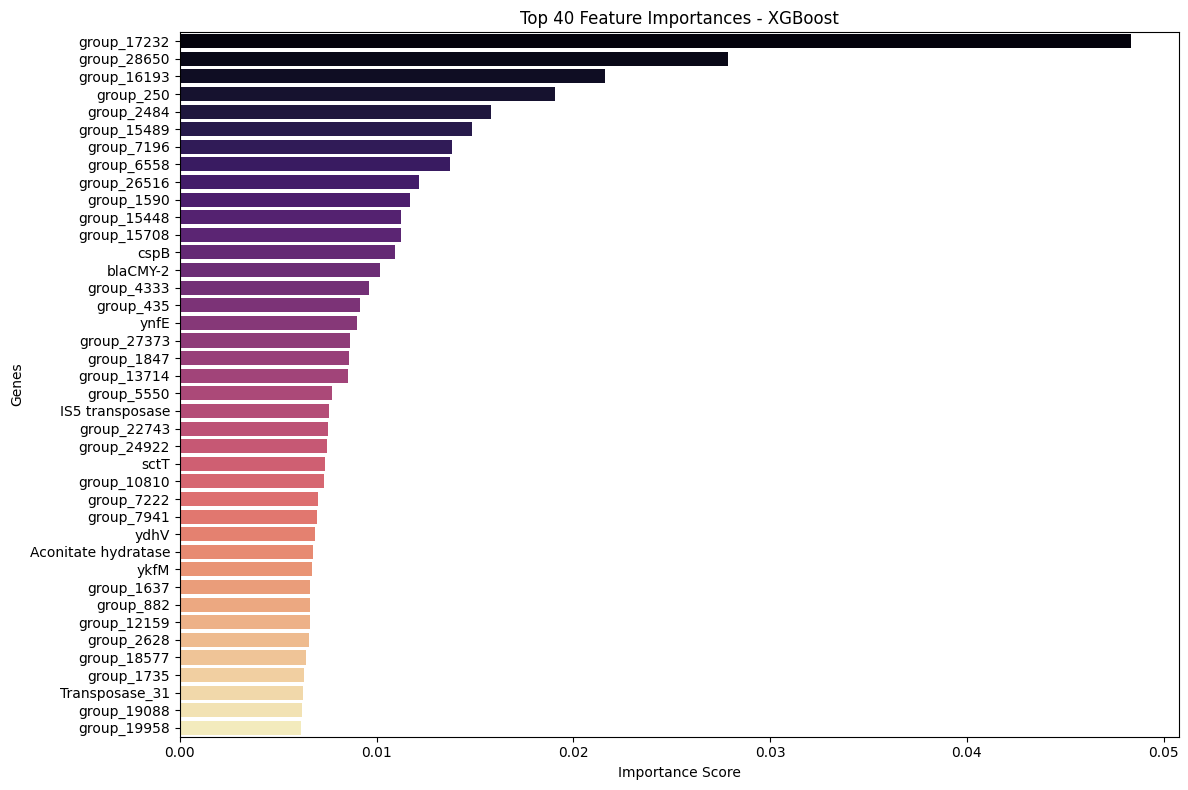

In [88]:
importances_xgb = xgb_classifier.feature_importances_

feature_names = X.columns
feature_importances_xgb = pd.Series(importances_xgb, index=feature_names).sort_values(ascending=False)

# Plot Top 20 Feature Importances
top_n = 40
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances_xgb[:top_n], y=feature_importances_xgb.index[:top_n], palette='magma')
plt.title('Top 40 Feature Importances - XGBoost')
plt.xlabel('Importance Score')
plt.ylabel('Genes')
plt.tight_layout()
plt.show()


Vemos que los genes que son mas importantes son diferentes en el caso del análisis de Random Forest. Esto se puede explicar por las diferencias entre ambos algoritmos, pero requiere una exploración mas en detalle.

## Conclusiones

El análisis realizado en este proyecto sugiere que es posible utilizar la presencia/ausencia de genes para realizar un análisis que nos permita identificar el lugar de origen de estas cepas. Para poder evaluar en mayor detalle, se requieren algunas consideraciones:

- El set de datos actual esta poco balanceado, con un mayor número de cepas comunitarias (MAUCO), lo cual introduce ruido en las predicciones. Esto se puede ver en las matrices de confusión en donde hay un mayor numero de cepas mal clasificadas en esta categoria.
- No se realizó ningun tipo de optimización de parametros en los modelos de clasificación. Con un análisis mas profundo, debiese ser posible llegar a mayores valores de precisión tanto en el modelo de Random Forest como XGBoost, reduciendo el número de variables de entrada y optimizando parametros.

Pese a esto, aún sin una gran optimización de parametros, llegamos a valores de precisión cercanos al 80%. Además de optimizar parametros, el paso siguiente en este estudio sería tomar cepas que no fueron incoporadas en estos modelos, y evaluar si somos capaces de identificar su origen.